<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/X_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import nan, linspace, min, max, reshape, mean, int64, float64, random
from pandas import DataFrame, read_csv, concat, set_option
set_option('display.max_columns', None)
set_option('display.max_rows', None)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from scipy.stats import norm, shapiro
!pip install researchpy
from researchpy import summary_cont
from gc import collect
from IPython.display import clear_output
clear_output()

In [ ]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep pandas_profiling
!pip list | grep matplotlib
!pip list | grep plotly
!pip list | grep xgboost
!pip list | grep scikit-learn
!pip list | grep scipy
!pip list | grep researchpy
!pip list | grep ipython

numpy                         1.18.5         
pandas                        1.0.5          
pandas-datareader             0.8.1          
pandas-gbq                    0.11.0         
pandas-profiling              2.8.0          
sklearn-pandas                1.8.0          
matplotlib                    3.2.2          
matplotlib-venn               0.11.5         
plotly                        4.4.1          
xgboost                       0.90           
scikit-learn                  0.22.2.post1   
scipy                         1.4.1          
researchpy                    0.2.3          
ipython                       5.5.0          
ipython-genutils              0.2.0          
ipython-sql                   0.3.9          


In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              
              dtype={'X1': 'int64',
                     'Y1': 'int64',
                     'X2': 'int64',
                     'Y2': 'int64',
                     'MID_POINT_X': 'float64',
                     'MID_POINT_Y': 'float64',
                     'Area': 'int64',
                     'long': 'float64',
                     'lat': 'float64',
                     'Long_minus': 'int64',
                     'Lat_minus': 'int64',},
              
              low_memory=True,
              usecols='X1 X2 MID_POINT_X'.split())

data = create_table(df.head())
data.show()

In [ ]:
del data
collect() # Garbage collection

41484

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',},
          inplace=True,) # Rename the column in the same dataframe

ren = create_table(df.head())
ren.show()

In [ ]:
del ren
collect()

17255

In [ ]:
print(df.columns.values)

['X1' 'X2' 'MPX']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19072

In [ ]:
frames = [df.head(), df.tail()]
conc_data_row = concat(frames,
                       axis=0, # Row-wise operation
                       join='outer',) # Returns both dataframes' columns

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
assert df['X1'].notnull().all()
assert df['X2'].notnull().all()
assert df['MPX'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


X1    NaN
X2    NaN
MPX   NaN
dtype: float64

In [ ]:
df.drop_duplicates(keep=False, # Drop all duplicates
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5, 
               how='all', # Only drop columns when all values are NA
               axis='columns',)
df.shape

(18, 3)

In [ ]:
df.info(memory_usage='deep') # Actual memory usage calculation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      18 non-null     int64  
 1   X2      18 non-null     int64  
 2   MPX     18 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 576.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='X-Midpoint Report',
                        explorative=True, # Deeper data insights
                        progress_bar=True,)
profile.to_notebook_iframe() # Display report in output console

In [ ]:
del profile
collect()

58650

In [ ]:
# Checking the distribution of the target variable
DataToTest = df['MPX']
stat, p = shapiro(DataToTest)
print('stat=%.2f, p=%.30f' % (stat, p))

if p > 0.05:
    print('Normal distribution')
else:
    print('Not a normal distribution')

stat=0.91, p=0.099587678909301757812500000000
Normal distribution


In [ ]:
random.seed(10) # Random values but constant
sample_size = 18
sample = random.choice(a= df['MPX'],
                       size = sample_size,)
z_critical = norm.ppf(q = 0.95)  
print("z-critical value: ",
      z_critical,)   

z-critical value:  1.6448536269514722


In [ ]:
summary = summary_cont(df[['X1',
                           'X2',
                           'MPX',]])

summary = create_table(summary)
summary.show()

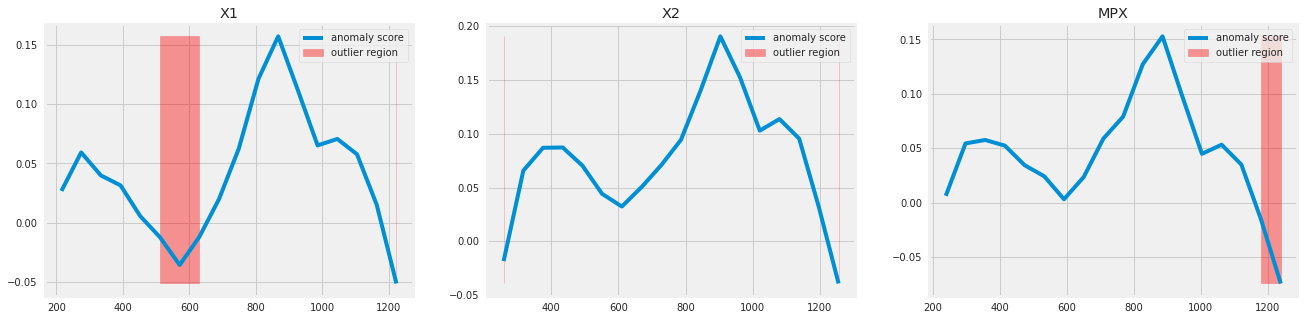

In [ ]:
cols = df
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)
fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.reshape(-1) # Return a 1D array

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1) # Outlier thresh
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1)) # 2D array

    xx = linspace(df[column].min(), # Starting value of the sequence
                  df[column].max(), # End value of the sequence
                  len(df), # No. of samples to generate
                  endpoint=True,).reshape(-1, 1) # End value = Last sample
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score), # Minimum boundary
                        max(anomaly_score), # Maximum boundary
                        where=outlier==-1, # Threshold to fill in a curve
                        color='r', # Fill color
                        alpha=.4, # See overlapped shaded regions
                        label='outlier region',)
    axs[i].legend(frameon=True) # Show box enclosing the legend text
    axs[i].set_title(column)

In [ ]:
any(df.X1 <= 0)

False

In [ ]:
any(df.X2 <= 0)

False

In [ ]:
any(df.MPX <= 0)

False

In [ ]:
# Define predictor (X) and target variables (y)
X = df[['X1',
        'X2',]]

y = df['MPX'].to_numpy().reshape(-1, 1)

The predictors variables defined above (X1 and X2) were determined through Recursive Feature Elimination (RFE) and their feature importance. The following code is not a direct part of this notebook. The reason I've not included this code as a direct part of the notebook is due to the fact that RFE requires all features to be included which I'm not a fond of since after the RFE process, I'll have to update related variables.



```
from numpy import int64, float64
from pandas import DataFrame, read_csv
from plotly.figure_factory import create_table
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFE

# Show data
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              
              dtype={'X1': 'int64',
                     'Y1': 'int64',
                     'X2': 'int64',
                     'Y2': 'int64',
                     'MID_POINT_X': 'float64',
                     'MID_POINT_Y': 'float64',
                     'Area': 'int64',
                     'long': 'float64',
                     'lat': 'float64',
                     'Long_minus': 'int64',
                     'Lat_minus': 'int64',},
              
              low_memory=True,)

data = create_table(df.head())
data.show()

df.rename(columns={'MID_POINT_X': 'MPX',
                   'MID_POINT_Y': 'MPY',}
          inplace=True,) # Rename the columns in the same dataframe

ren = create_table(df.head())
ren.show()

# Define predictor (X) and target variables (y)
X = df[['X1',
        'Y1',
        'X2',
        'Y2',
        'MPY',
        'Area',
        'long',
        'lat',
        'Long_minus',
        'Lat_minus',]]

y = df['MPX'].to_numpy().reshape(-1, 1)

# Define the model
regr = CatBoostRegressor(iterations=7000, 
                         depth=4, 
                         learning_rate=0.02, 
                         loss_function='RMSE', 
                         subsample=0.9,
                         grow_policy='Depthwise',
                         l2_leaf_reg=2,
                         rsm=0.9,
                         verbose=0,)

# Performing RFE
rfe = RFE(regr, 3)
fit = rfe.fit(X, y,)
print("Num features: {}".format(fit.n_features_))
print("Selected features: {}".format(fit.support_))
print("Feature ranking: {}".format(fit.ranking_))
________________________________________________________________________________
Output: Num features: 3
        Selected features: [ True  True False False False False False False False  True]
        Feature ranking: [1 1 4 6 3 5 7 2 8 1]
________________________________________________________________________________
# Calculate feature importance
regr.fit(X, y,)
print(regr.feature_importances_)
________________________________________________________________________________
Output: [27.04260174 36.40487156  2.04547475  4.41668907  3.42191053  5.44478804
         1.57089372 10.18206005  1.08344147  8.38726907]
```



In [ ]:
imp = KNNImputer(missing_values=nan, # Missing values marked as nan
                 n_neighbors=5, # No. of nearby values
                 weights='distance', # Nearest value = Greatest influence
                 metric='nan_euclidean',)

In [ ]:
regr = XGBRegressor(learning_rate=0.01, 
                    n_estimators=3460,
                    max_depth=3, 
                    min_child_weight=0,
                    gamma=0, 
                    subsample=0.6,
                    colsample_bytree=0.6,
                    objective='reg:squarederror',
                    nthread=-1,
                    scale_pos_weight=1,
                    seed=26,
                    reg_alpha=0.00006,)

In [ ]:
pipeline = make_pipeline(imp, regr)
pipeline.fit(X, y.reshape(-1),)

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.6, gamma=0,
                              importance_type='gain', learning_rate=0.01,
                              max_delta_step=0, max_depth=3, min_child_weight=0,
                              missing=None, n_estimators=3460, n_jobs=1,
                              nthread=-1, objective='reg:squarederror',
                              random_state=0, reg_alpha=6e-05, reg_lambda=1,
                              scale_pos_weight=1, seed=26, silent=None,
                              subsample=0.6, verbosity=1))],
         ve

In [ ]:
scores = cross_val_score(pipeline,
                         X, y.reshape(-1),
                         cv=18, # 18-fold split
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[ -1.60321045 -18.5758667  -74.55786133  -0.14318848 -31.87258911
  -6.41717529 -14.43469238 -47.2253418  -36.18066406 -59.77038574
  -1.47070312 -11.93237305 -20.65429688 -11.28833008  -0.1348877
  -1.60145569 -22.39660645  -6.42596436]


In [ ]:
mean_scores = (-1 * scores.mean())
print('RMSE: {:.10f}'.format(mean_scores))

RMSE: 20.3714218140


# Disclaimer
The following line plot is not a direct part of the above code. However, this graph visualizes the difference between the actual values *(y)* and the predicted values of *y*, when **RMSE is 51.1815**. Note that the RMSE of the model in this notebook is **20.3714**, which is lesser than the former. The former, greater RMSE was calculated as follows:

```
from numpy import sqrt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# Perform predictions
pred = cross_val_predict(pipeline,
                         X, y.reshape(-1),
                         cv=2, # 2-fold split to avoid overfitting the model
                         n_jobs=-1,) # Use every CPU core
print(pred)

# Calculate the RMSE
print('RMSE: %.10f'
      % sqrt(mean_squared_error(y,
                                pred.reshape(-1),)))

# Create a dataframe to compare the actual and predicted values
result = DataFrame({'Actual': y.flatten(),
                    'Predicted': pred.flatten(),})

res = create_table(result.head())
res.show()

# Visualize the difference between actual and predicted values
result.plot(kind='line',
            figsize=(14, 5))

plt.grid(which='major', 
         linestyle='-', 
         linewidth='0.5', 
         color='green',)

plt.grid(which='minor', 
         linestyle=':', 
         linewidth='0.5', 
         color='black',)

plt.legend(frameon=True)
plt.show()
```
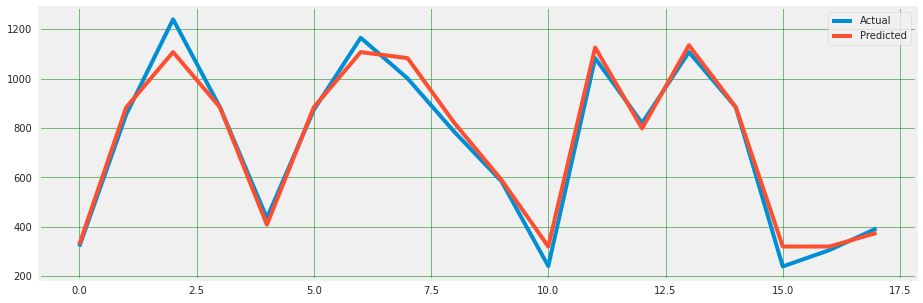

*In case you are confused why I splitted the data in 18 folds in the case of cross_val_score, while only 2 folds in the case of cross_val_predict. This is due to the reason that increasing folds in cross_val_score method does not cause overfitting while in cross_val_predict it does. More technical differences between cross_val_score and cross_val_predict can be found here:*

 https://stackoverflow.com/questions/41458834/how-is-scikit-learn-cross-val-predict-accuracy-score-calculated
